# script that quantifies how loops correlate with gene expression and chromatin accessibility

In [1]:
import pandas as pd
import numpy as np
import hicstraw 
from multiprocessing import Pool
from functools import partial
import glob
import os
import plotly.express as px
import math
import matplotlib.pyplot as plt
from matplotlib import colors
from pandarallel import pandarallel
import cooler
import cooltools
import pybedtools as pbed
pandarallel.initialize()
from scipy import stats, special
from statsmodels.stats import multitest
import statsmodels.api as sm
import statsmodels.formula.api as smf
import plotly.io as pio
import seaborn as sns
os.makedirs("/mnt/iusers01/jw01/mdefscs4/scratch/temp_pybedtools/", exist_ok = True)
pbed.helpers.set_tempdir("/mnt/iusers01/jw01/mdefscs4/scratch/temp_pybedtools/")
bed_genome_file = "/mnt/iusers01/jw01/mdefscs4/hg38.genome"

plt.rcParams['svg.fonttype'] = 'none'

base_dir = "/mnt/jw01-aruk-home01/projects/psa_functional_genomics/PsA_cleaned_analysis"

INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
gtf_annotation_df = pd.read_pickle(f"{base_dir}/gencode_gtf.pickle")
gtf_transcripts = gtf_annotation_df[(gtf_annotation_df["feature"] == "transcript") & (gtf_annotation_df["transcript_type"] == "protein_coding")].dropna(axis=1, how='all')
gtf_transcripts["gene_id"] = gtf_transcripts["gene_id"].str.split(".").str[0]
gtf_transcripts["transcript_id"] = gtf_transcripts["transcript_id"].str.split(".").str[0]
gtf_transcripts["TSS_start"] = gtf_transcripts.apply(lambda x: int(x["start"]) if x["strand"] == "+" else int(x["end"]) ,axis = 1)

In [3]:
RNA_normalized_counts = pd.read_csv(f"{base_dir}/RNA_seq_analysis/RNA_normalized_counts.csv")
metadata_RNA = pd.read_csv(f"{base_dir}/metadata/cleaned_RNA_metadata.csv", index_col=0)
column_name_dict = dict(zip(metadata_RNA['sample'], metadata_RNA['proper_name']))
RNA_normalized_counts = RNA_normalized_counts.rename(columns=column_name_dict)
RNA_normalized_counts_melted = pd.melt(RNA_normalized_counts, id_vars=["ensembl","ENSG","symbol","genename","entrez"], 
        value_vars=RNA_normalized_counts.columns.difference(["ensembl","ENSG","symbol","genename","entrez"]),
        var_name="proper_name",value_name="expression")
RNA_normalized_counts_melted = RNA_normalized_counts_melted.merge(metadata_RNA[["patient","cell_type","condition","proper_name"]], on = "proper_name")

# RNA_normalized_counts_melted = RNA_normalized_counts_melted[RNA_normalized_counts_melted["cell_type"].isin(["CD4","CD8"])]

In [4]:
RNA_diff = pd.read_csv(f"{base_dir}/RNA_seq_analysis/DEseq2_result/DE_CD8_vs_CD4_all.csv", index_col = 0)

In [5]:
ATAC_normalised_counts = pd.read_csv(f"{base_dir}/ATAC_seq_analysis/ATAC_DESeq2_quantile_normalized_counts.csv", index_col = 0)
metadata_ATAC = pd.read_csv(f"{base_dir}/metadata/cleaned_ATAC_metadata.csv", index_col=0)

column_name_dict = dict(zip(metadata_ATAC['id'], metadata_ATAC['proper_name']))
ATAC_normalised_counts = ATAC_normalised_counts.rename(columns=column_name_dict)
ATAC_normalised_counts_melted = pd.melt(ATAC_normalised_counts, id_vars=["CHR","START","END"], 
        value_vars=ATAC_normalised_counts.columns.difference(["CHR","START","END"]),
        var_name="proper_name",value_name="peak_height")
ATAC_normalised_counts_melted = ATAC_normalised_counts_melted.merge(metadata_ATAC[["patient","cell_type","condition","proper_name"]], on="proper_name", suffixes = ["", "_y"])

# ATAC_normalised_counts_melted = ATAC_normalised_counts_melted[ATAC_normalised_counts_melted["cell_type"].isin(["CD4","CD8"])]

In [6]:
ATAC_diff = pd.read_csv(f"{base_dir}/ATAC_seq_analysis/diffbind_result/DE_CD8_vs_CD4_all.csv", index_col = 0)

## show if it matters if loop overlaps gene promoter

### annotate the loops with the genes that overlap it

In [7]:
loops_analysed = pd.read_pickle(f"{base_dir}/HiC_analysis/extracting_loop_counts/aggregated_counts/aggregated_normalized_loops_CD4_CD8.pk")
metadata_hic = pd.read_csv(f"{base_dir}/metadata/cleaned_HiC_metadata.csv", index_col = 0)
column_name_dict = dict(zip(metadata_hic['folder_name'], metadata_hic['proper_name']))
loops_analysed = loops_analysed.rename(columns=column_name_dict)
# only do chr1 to save time

loops_analysed = loops_analysed[loops_analysed["chrA"] == "1"]

loops_counts_melted = pd.melt(loops_analysed, id_vars=['chrA', 'A_start', 'A_end', 'chrB', 'B_start', 'B_end', 'FDR', 'DETECTION_SCALE', 'distance_bin'], 
        value_vars=loops_analysed.columns.difference(['chrA', 'A_start', 'A_end', 'chrB', 'B_start', 'B_end', 'FDR', 'DETECTION_SCALE', 'distance_bin']),
        var_name="proper_name",value_name="interaction_strength")

loops_counts_melted = loops_counts_melted.merge(metadata_hic[["patient","cell_type","condition","proper_name"]], on = "proper_name")

only annotate the genes that are expressed in our cells

In [8]:
gtf_transcripts_expressed = gtf_transcripts[gtf_transcripts["gene_id"].isin(RNA_normalized_counts["ENSG"].to_list())]

In [9]:
def retrieve_genes(chr,start,end):
    if not chr.startswith("chr"):
        chr = "chr" + chr
    genes = gtf_transcripts_expressed[(gtf_transcripts_expressed["seqname"] == chr) & (gtf_transcripts_expressed["TSS_start"] > start) & (gtf_transcripts_expressed["TSS_start"] < end)]
    return genes["gene_id"].drop_duplicates().to_list()

def retrieve_genes_overlapping(row):
    genes_A = retrieve_genes(row["chrA"],row["A_start"],row["A_end"])
    genes_B = retrieve_genes(row["chrB"],row["B_start"],row["B_end"])
    return list(set(genes_A + genes_B))

def retrieve_containing(row):
    return retrieve_genes(row["chrA"],row["A_start"],row["B_end"])

def retrieve_surrounding(row):
    return retrieve_genes(row["chrA"],row["A_start"] - 4000000, row["B_end"] + 4000000)

In [10]:
loops_analysed["genes_overlapping"] = loops_analysed.parallel_apply(retrieve_genes_overlapping, axis = 1)
loops_analysed["genes_contained"] = loops_analysed.parallel_apply(retrieve_containing, axis = 1)
loops_analysed["genes_surrounding"] = loops_analysed.parallel_apply(retrieve_surrounding, axis = 1)

In [11]:
def retrieve_gene_corr(row):
    def retrieve_p_vals_gene(this_gene):
        merged_df = loop_intensities.merge(RNA_normalized_counts_melted[RNA_normalized_counts_melted["ENSG"] == this_gene], on = "proper_name")
        s = smf.ols("interaction_strength~expression", data = merged_df) # interaction_strength~expression+cell_type+condition_x
        r = s.fit()
        return pd.concat((pd.Series({"p_value":r.pvalues.T["expression"],
            "beta":r.params.T["expression"],
            "R_squared":r.rsquared,
            "R_squared_ajd":r.rsquared_adj,
            "interaction_mean": merged_df["interaction_strength"].mean(),
            "expression_mean":merged_df["expression"].mean(),"gene":this_gene}), row))
    loop_intensities = loops_counts_melted[(loops_counts_melted["chrA"] == row["chrA"]) & 
        (loops_counts_melted["A_start"] == row["A_start"]) & 
        (loops_counts_melted["B_start"] == row["B_start"])]
    res = []
    for gene in row["genes_surrounding"]:
        res.append(retrieve_p_vals_gene(gene))
    if len(res) == 1:
        return res[0].to_frame().T
    else:
        return pd.concat(res,axis = 1).T

In [12]:
hic_diff = pd.read_csv(f"{base_dir}/HiC_analysis/output_results/DE_loops_CD8_vs_CD4.csv", index_col = 0, dtype = {"chrA":str,"chrB":str})
loops_analysed_subset = loops_analysed.merge(hic_diff[(hic_diff["FDR"] < 0.01) & (hic_diff["base_mean"] > 10) & (hic_diff["chrA"] == "1")][["chrA","A_start","B_start"]],how="inner")

In [13]:
res = loops_analysed_subset[(loops_analysed_subset["genes_surrounding"].map(len) > 0)].parallel_apply(retrieve_gene_corr, axis = 1, result_type = "reduce")

In [14]:
out = pd.concat(res.to_list())
out["gene_is_contained"] = out.apply(lambda x: 1 if x["gene"] in x["genes_contained"] else 0, axis = 1)
out["gene_is_overlapping"] = out.apply(lambda x: 1 if x["gene"] in x["genes_overlapping"] else 0, axis = 1)

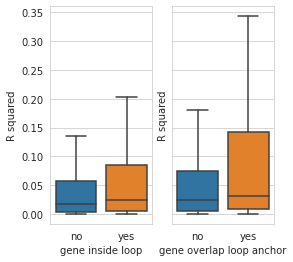

In [29]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(1,2, figsize = (4,4), sharey = True, facecolor=(0, 0, 0, 0))
sns.boxplot(data = out[out["gene_is_contained"] == 1], y = "R_squared", x = "gene_is_overlapping", ax=axes[1], showfliers=False)
axes[1].set_xlabel("gene overlap loop anchor")
axes[1].set_xticklabels(["no","yes"])
axes[1].set_ylabel("R squared")
sns.boxplot(data = out, y = "R_squared", x = "gene_is_contained", ax=axes[0], showfliers=False)
axes[0].set_xlabel("gene inside loop")
axes[0].set_xticklabels(["no","yes"])
axes[0].set_ylabel("R squared")
fig.savefig(f"{base_dir}/integration_analysis/figures/RNA_correlations_loops.png", dpi = 600)
fig.savefig(f"{base_dir}/integration_analysis/figures/RNA_correlations_loops.svg", dpi = 600)

## Show the same thing for ATAC-seq peaks

In [16]:
def associated_loops(df):
    def retrieve_p_vals(this_peak):
        this_peak = this_peak.merge(df[["proper_name","interaction_strength"]], on = "proper_name")
        s = smf.ols("interaction_strength~peak_height", data = this_peak) # interaction_strength~peak_height+cell_type+condition
        r = s.fit()
        return pd.Series({"p_value":r.pvalues.T["peak_height"],
                            "beta":r.params.T["peak_height"],
                            "R_squared":r.rsquared,
                            "R_squared_ajd":r.rsquared_adj,
                            "interaction_mean": df["interaction_strength"].mean(),
                            "peak_mean":this_peak["peak_height"].mean(),})
    def overlaps_loop(row):
        if row["END"] > df["A_start"].iloc[0] and row["START"] < df["A_end"].iloc[0]:
            return 1
        elif row["END"] > df["B_start"].iloc[0] and row["START"] < df["B_end"].iloc[0]:
            return 1
        else:
            return 0
    df_peaks = ATAC_normalised_counts_melted[(ATAC_normalised_counts_melted["CHR"] == "chr" + str(df["chrA"].iloc[0])) & 
        ((ATAC_normalised_counts_melted["START"] > (df["A_start"].iloc[0] - 4000000)) & 
        (ATAC_normalised_counts_melted["END"] < (df["B_end"].iloc[0] + 4000000)))]
    pvals = df_peaks.groupby(['CHR', 'START', 'END']).apply(retrieve_p_vals).reset_index()
    pvals["FDR"] = multitest.fdrcorrection(pvals["p_value"], alpha = 0.1)[1]
    pvals["inside_loop"] = pvals.apply(lambda row: 1 if row["START"] > df["A_start"].iloc[0] and row["END"] < df["B_end"].iloc[0] else 0, axis = 1)
    pvals["overlap_loop"] = pvals.apply(overlaps_loop, axis = 1)
    return pvals

In [17]:
loops_counts_melted_filt = loops_counts_melted.merge(hic_diff[(hic_diff["FDR"] < 0.01) & (hic_diff["base_mean"] > 10) & (hic_diff["chrA"] == "1")][["chrA","A_start","B_start"]],how="inner")
corr_all = loops_counts_melted_filt.groupby(["chrA","A_start","B_start"]).parallel_apply(associated_loops)

In [18]:
corr_filtered = corr_all[(corr_all["interaction_mean"] > 10) & (corr_all["peak_mean"] > 10)]
corr_filtered = corr_filtered.reset_index()
corr_filtered["far_away"] = corr_filtered.apply(lambda x: 1 if x["END"] < (x["A_start"] - 250000) or x["START"] > (x["B_start"] + 250000) else 0, axis = 1)

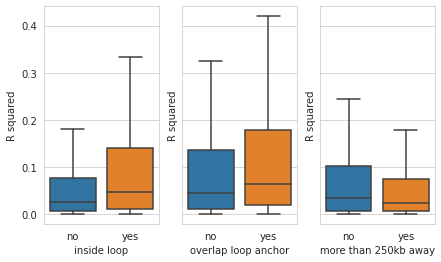

In [30]:
fig, axes = plt.subplots(1,3, figsize = (7,4), sharey = True, facecolor=(0, 0, 0, 0))
sns.boxplot(data = corr_filtered, y = "R_squared", x = "inside_loop", ax=axes[0], showfliers=False)
axes[0].set_xlabel("inside loop")
axes[0].set_xticklabels(["no","yes"])
axes[0].set_ylabel("R squared")
sns.boxplot(data = corr_filtered[corr_filtered["inside_loop"] == 1], y = "R_squared", x = "overlap_loop", ax=axes[1], showfliers=False)
axes[1].set_xlabel("overlap loop anchor")
axes[1].set_xticklabels(["no","yes"])
axes[1].set_ylabel("R squared")
sns.boxplot(data = corr_filtered, y = "R_squared", x = "far_away", ax=axes[2], showfliers=False)
axes[2].set_xlabel("more than 250kb away")
axes[2].set_xticklabels(["no","yes"])
axes[2].set_ylabel("R squared")
fig.savefig(f"{base_dir}/integration_analysis/figures/ATAC_correlations_loops.png", dpi = 600)
fig.savefig(f"{base_dir}/integration_analysis/figures/ATAC_correlations_loops.svg", dpi = 600)